In [ ]:
# Change runtime to GPU in Colab: Runtime > Change runtime type > GPU
!nvidia-smi

# Install required libraries
!pip -q install -U transformers accelerate datasets evaluate scikit-learn


Sun Aug 24 13:16:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os, random, numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
import torch

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Model & training config
MODEL_NAME = "hfl/chinese-roberta-wwm-ext"  # Pretrained Chinese XLNet
NUM_LABELS = 2                         # Depression = 1, Non-depression = 0
MAX_LEN = 256                          # Max tokens per text
BATCH_SIZE = 16                        # Reduce if GPU OOM
EPOCHS = 6                             # Good start (can tune 5-8)
LR = 2e-5                              # Learning rate

In [ ]:
from google.colab import files
uploaded = files.upload()

# If it's a zip file, extract it
import zipfile, os

for fn in uploaded.keys():
    if fn.endswith(".zip"):
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall("/content/WU3D")
        print("Extracted files:", os.listdir("/content/WU3D"))
    else:
        print("Uploaded file:", fn)


Saving WU3D (1).zip to WU3D (1).zip
Extracted files: ['normal.json', 'depressed.json']


In [ ]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove only control characters (not Chinese/emoji/punctuations)
    text = re.sub(r"[\r\n\t]", " ", text)
    # Normalize multiple spaces
    text = " ".join(text.split())
    return text.strip()

df["text"] = df["text"].astype(str).apply(clean_text)
df = df[df["text"].str.strip() != ""].reset_index(drop=True)

print(df.head(10))
print("Shape after cleaning:", df.shape)

   label                                               text
0      1  有点累想休息了 为什么总有领导作为外行人在不了解的情况下就异想天开的安排人做一些完全不可能做...
1      1  轉發微博 轉發微博 张艺兴joker为了肚子穿的宽松 苏州 人活着最重要的就是开心啦 苏州 ...
2      1  抑郁症的普及它好就好在 以前人抑郁的时候想死 现在人抑郁的时候想我要不要吃点药看看医生 抑郁...
3      1  感觉坚持不下去了我想解脱了 晚上饿猛啃了几根辣条现在肚子胀的难受 拘泥于自己的鸡心螺壳中是什...
4      1  所有人都问我你没事吧你还好吧 我笑着一一回答我很好啊没有问题没事的你看我像有什么事的样子吗 ...
5      1  害з∠ 每天除了吃饭睡觉就是喂奶吸奶 每天都是吐不出来的恶心反胃 每次醒来都会以为又过了一天...
6      1  反胃 每次脆弱的时候阳光总是突然出现 谁爱我我爱谁 真特么烦打麻将的 无的对视10秒20秒兄...
7      1  总是莫名其妙流眼泪 感觉生活无趣 我感觉自己好压抑 不为什么 没有原因 这是不是抑郁症的前兆...
8      1  回来啦 竟然为了追星下回来了 真的好讨厌自己 我的抑郁好像好了你们知道吗在我卸载的这段时间里...
9      1  在有缘网有一种爱明明是深爱却说不出来有一种爱明明想放手却无法离弃 有一种爱明知是煎熬却又躲不...
Shape after cleaning: (32568, 2)


In [ ]:
import os
os.listdir("/content")


['.config', 'WU3D (1).zip', 'WU3D', 'sample_data']

In [ ]:
import json
import pandas as pd

# Load JSON files from the WU3D folder
with open("/content/WU3D/depressed.json", "r", encoding="utf-8") as f:
    depressed = json.load(f)

with open("/content/WU3D/normal.json", "r", encoding="utf-8") as f:
    normal = json.load(f)

print("Depressed sample keys:", depressed[0].keys())
print("Normal sample keys:", normal[0].keys())


Depressed sample keys: dict_keys(['label', 'nickname', 'gender', 'profile', 'birthday', 'num_of_follower', 'num_of_following', 'all_tweet_count', 'original_tweet_count', 'repost_tweet_count', 'tweets'])
Normal sample keys: dict_keys(['label', 'nickname', 'gender', 'profile', 'birthday', 'num_of_follower', 'num_of_following', 'all_tweet_count', 'original_tweet_count', 'repost_tweet_count', 'tweets'])


In [ ]:
import pandas as pd

def extract_text(user):
    tweets = user.get("tweets", [])
    return " ".join([t.get("tweet_content", "") for t in tweets if "tweet_content" in t])

# Depressed = label 1
depressed_df = pd.DataFrame({
    "label": 1,
    "text": [extract_text(u) for u in depressed]
})

# Normal = label 0
normal_df = pd.DataFrame({
    "label": 0,
    "text": [extract_text(u) for u in normal]
})

# Combine
df = pd.concat([depressed_df, normal_df], ignore_index=True)
df = df[df["text"].str.strip() != ""].reset_index(drop=True)

print("Final dataset shape:", df.shape)
df.head(5)

Final dataset shape: (32568, 2)


,label,text
0,1,有点累想休息了 为什么总有领导作为外行人在不了解的情况下就异想天开的安排人做一些完全不可能做...
1,1,轉發微博 轉發微博 张艺兴joker为了肚子穿的宽松 苏州 人活着最重要的就是开心啦 苏州 ...
2,1,抑郁症的普及它好就好在 以前人抑郁的时候想死 现在人抑郁的时候想我要不要吃点药看看医生 抑郁...
3,1,感觉坚持不下去了我想解脱了 晚上饿猛啃了几根辣条现在肚子胀的难受 拘泥于自己的鸡心螺壳中是...
4,1,所有人都问我你没事吧你还好吧 我笑着一一回答我很好啊没有问题没事的你看我像有什么事的样子吗 ...


In [ ]:
# Depressed = label 1
depressed_df = pd.DataFrame({
    "label": 1,
    "text": [extract_text(u) for u in depressed]
})

# Normal = label 0
normal_df = pd.DataFrame({
    "label": 0,
    "text": [extract_text(u) for u in normal]
})

# Combine
df = pd.concat([depressed_df, normal_df], ignore_index=True)
df = df[df["text"].str.strip() != ""].reset_index(drop=True)

print("Final dataset shape:", df.shape)
df.head(5)


Final dataset shape: (32568, 2)


,label,text
0,1,有点累想休息了 为什么总有领导作为外行人在不了解的情况下就异想天开的安排人做一些完全不可能做...
1,1,轉發微博 轉發微博 张艺兴joker为了肚子穿的宽松 苏州 人活着最重要的就是开心啦 苏州 ...
2,1,抑郁症的普及它好就好在 以前人抑郁的时候想死 现在人抑郁的时候想我要不要吃点药看看医生 抑郁...
3,1,感觉坚持不下去了我想解脱了 晚上饿猛啃了几根辣条现在肚子胀的难受 拘泥于自己的鸡心螺壳中是...
4,1,所有人都问我你没事吧你还好吧 我笑着一一回答我很好啊没有问题没事的你看我像有什么事的样子吗 ...


In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=RANDOM_SEED)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=RANDOM_SEED)

print("Train/Val/Test:", train_df.shape, val_df.shape, test_df.shape)


Train/Val/Test: (26054, 2) (3257, 2) (3257, 2)


In [ ]:
from datasets import Dataset, DatasetDict

hf_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})
hf_ds


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 26054
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 3257
    })
})

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

MAX_LEN = 256

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

hf_ds = hf_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
hf_ds.set_format(type="torch")
hf_ds


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/26054 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 26054
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3257
    })
})

In [ ]:
from transformers import AutoModelForSequenceClassification

NUM_LABELS = 2
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)


pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

EPOCHS = 6
BATCH_SIZE = 16   # use 8 if GPU memory is low
LR = 2e-5

training_args = TrainingArguments(
    output_dir="xlnet-wu3d",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    warmup_ratio=0.06,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=RANDOM_SEED
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="binary"),
        "precision": precision_score(labels, preds, average="binary"),
        "recall": recall_score(labels, preds, average="binary"),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_ds["train"],
    eval_dataset=hf_ds["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.208100,0.223500,0.927234,0.884559,0.890196,0.878993
2,0.155000,0.208494,0.933067,0.888320,0.943417,0.839303
3,0.127700,0.260654,0.933681,0.891239,0.928646,0.856728
4,0.081300,0.397252,0.913417,0.867232,0.844180,0.891578
5,0.046900,0.427727,0.927848,0.883951,0.902218,0.866409


TrainOutput(global_step=8145, training_loss=0.13287825979580536, metrics={'train_runtime': 1882.5932, 'train_samples_per_second': 83.037, 'train_steps_per_second': 5.192, 'total_flos': 1.71377385908736e+16, 'train_loss': 0.13287825979580536, 'epoch': 5.0})

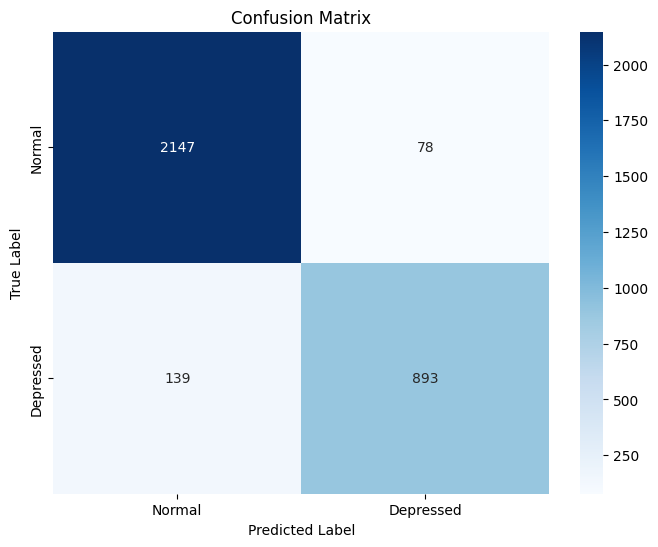

              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95      2225
   Depressed       0.92      0.87      0.89      1032

    accuracy                           0.93      3257
   macro avg       0.93      0.92      0.92      3257
weighted avg       0.93      0.93      0.93      3257



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions on the test set
predictions = trainer.predict(hf_ds["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Depressed'], yticklabels=['Normal', 'Depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(labels, preds, target_names=['Normal', 'Depressed']))

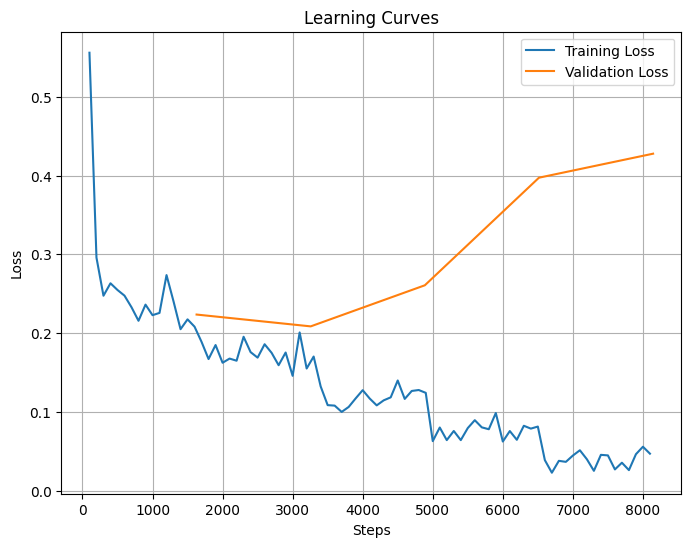

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
history = trainer.state.log_history

# Extract training and evaluation loss values
train_losses = [x['loss'] for x in history if 'loss' in x]
eval_losses = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Extract the corresponding steps for training losses and epochs for evaluation losses
train_steps = [x['step'] for x in history if 'loss' in x]
eval_epochs = [x['epoch'] for x in history if 'eval_loss' in x]


# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot([epoch * trainer.state.max_steps / trainer.state.num_train_epochs for epoch in eval_epochs], eval_losses, label='Validation Loss') # Approximate steps for eval loss
plt.title('Learning Curves')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()